# Multimodal Unsupervised Learning (Dimensionality Reduction)

## Setup

In [1]:
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy
import time

### Paths

In [2]:
input_path = '../../../2.data_preparation/out/fusion/'
output_path = '../out/dim_red'
# Global configuration path
glob_conf_path = '../../../config/global_config.py'

### Load gloabal variables

In [3]:
exec(open(glob_conf_path).read())

### Load data

In [4]:
multi_df = pd.read_csv(input_path + 'audio_video_dataset_unsupervised_learning.csv')
multi_df['emotion'] = multi_df['emotion_id'].map(emotion_id_to_emotion)
multi_df = multi_df.drop(columns=['emotion_id'])

In [5]:
multi_df.head()

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,emotion
0,0.579782,0.276111,0.533631,0.596311,0.632179,0.209500,0.178389,0.032262,0.261604,0.070276,...,0.391106,0.112723,0.033404,0.133362,0.016468,0.019319,0.394809,0.123362,0.024128,amusement
1,0.393945,0.343674,0.384970,0.423466,0.446001,0.147274,0.282919,0.175538,0.267522,0.068505,...,0.292710,0.074774,0.029097,0.082065,0.028774,0.016000,0.246774,0.110516,0.023097,amusement
2,0.487920,0.288303,0.466380,0.452395,0.584362,0.226165,0.321936,0.164298,0.311106,0.203101,...,0.457659,0.221317,0.024927,0.105854,0.022000,0.055171,0.179024,0.128976,0.015366,amusement
3,0.415525,0.320765,0.357067,0.355146,0.490685,0.233617,0.187911,0.038932,0.222829,0.040867,...,0.298545,0.180061,0.031030,0.073758,0.022121,0.034182,0.153212,0.168485,0.009576,amusement
4,0.578382,0.277224,0.455800,0.559710,0.627945,0.291699,0.210346,0.112102,0.258617,0.044221,...,0.353421,0.246211,0.010053,0.095368,0.011947,0.047632,0.182842,0.058526,0.019526,amusement


## Dimensionality reduction

### Exploration

#### Standard deviation

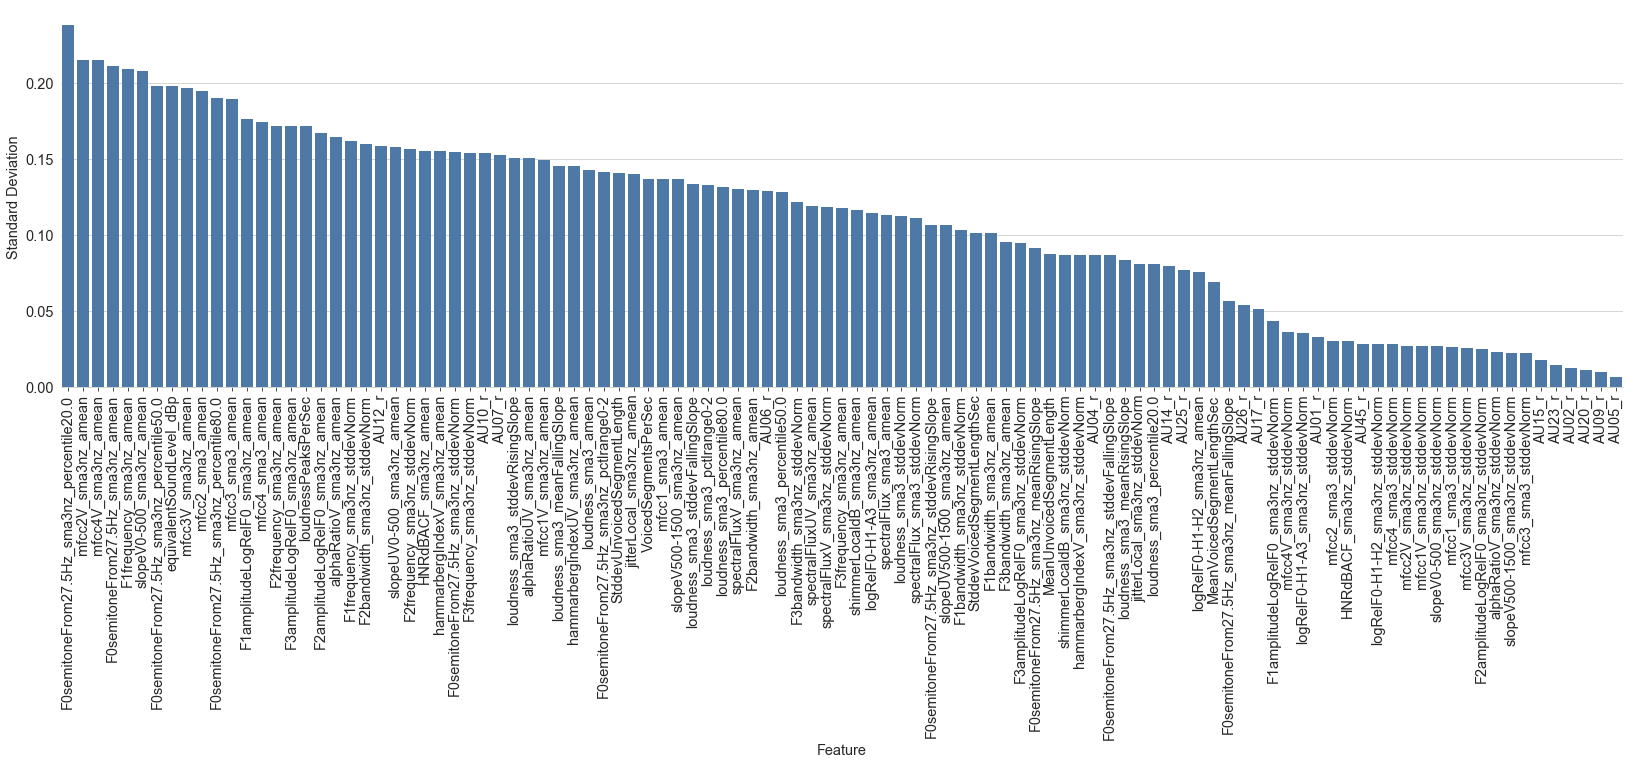

In [10]:
X = multi_df.drop(columns='emotion')
std = X.std().sort_values(ascending=False)

plt.figure(figsize=[28,7])
matplotlib.rcParams.update({'font.size': 14.5})
sns.set_style({'xtick.bottom': True})
sns.barplot(x=std.index, y=std.values, color=blue_rgb, saturation=sns_saturation)
plt.xticks(rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Standard Deviation')
plt.savefig(os.path.join(output_path,'charts','report_std_expl_dim_red.svg'), bbox_inches = 'tight')
sns.set_style({'xtick.bottom': False})
matplotlib.rcParams.update({'font.size': 13})

https://youtu.be/ioXKxulmwVQ?t=770

With this chart we can see how much variation our dimensions have. We could drop those variables with almost zero variation.

#### Pairwise correlations

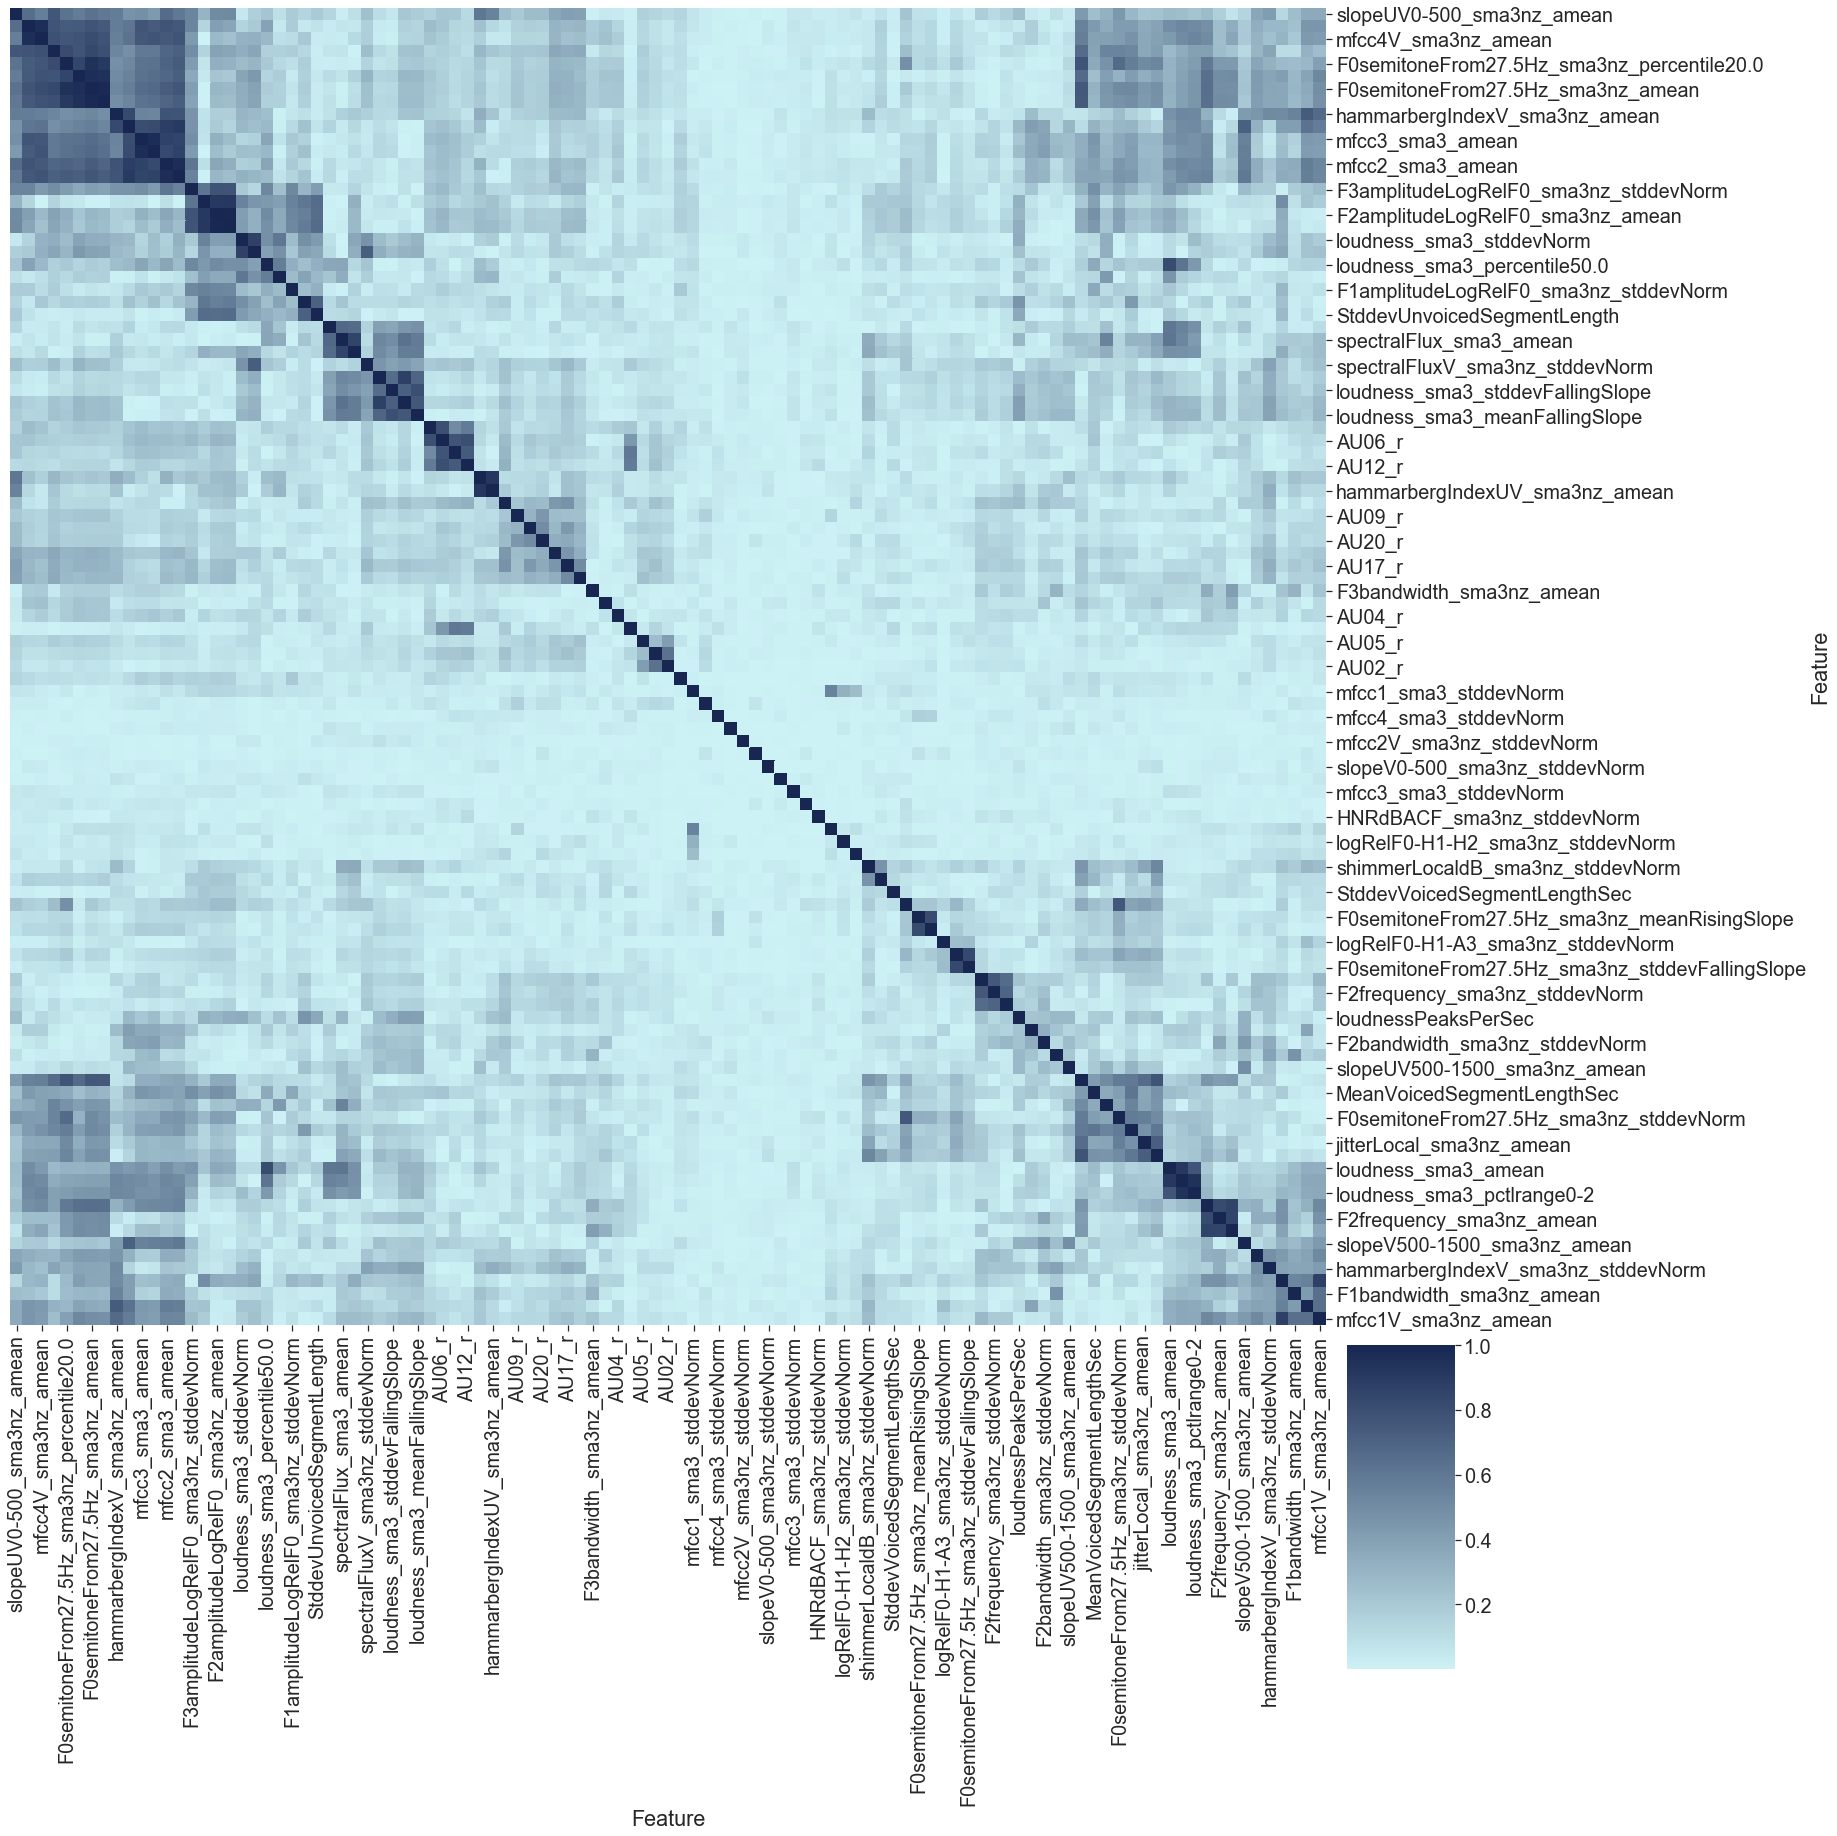

In [32]:
X = multi_df.drop(columns='emotion')

# Create correlation matrix
corr_matrix = X.corr().abs()
matplotlib.rcParams.update({'font.size': 14.5})
sns.set_style({'ytick.right': True})
sns.set_style({'xtick.bottom': True})
cg=sns.clustermap(corr_matrix, cmap=pos_cmap, metric='cityblock', cbar_pos=(0.78, 0.07, 0.05, 0.15), figsize=(30,30))
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
ax = cg.ax_heatmap
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
ax.set_xlabel("Feature")
ax.set_ylabel("Feature")
plt.savefig(os.path.join(output_path,'charts','report_corr_expl_dim_red.svg'), bbox_inches = 'tight')
sns.set_style({'ytick.right': False})
sns.set_style({'xtick.bottom': False})
matplotlib.rcParams.update({'font.size': 13})

https://youtu.be/ioXKxulmwVQ?t=899

We could drop highly correlated features.

#### PCA

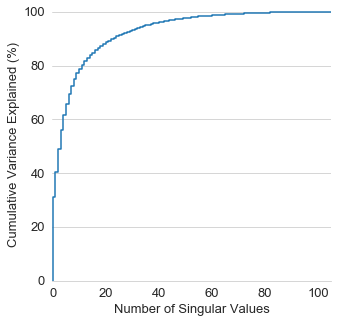

In [6]:
from sklearn.decomposition import PCA

X = multi_df.drop(columns='emotion')
pca = PCA().fit(X)

expl_var_rat = pca.explained_variance_ratio_
cum_sum_expl_var_perc = np.array(([0] + list(np.cumsum(expl_var_rat))))*100

plt.figure(figsize=[5,5])
#sns.set_style({'axes.spines.left': False, 'axes.spines.top': False, 'axes.spines.right': False})
plt.step(x=range(0,len(cum_sum_expl_var_perc)),y=cum_sum_expl_var_perc)
plt.xlim([-0.2,len(expl_var_rat)])
plt.ylim([0,101])
plt.grid(axis='x')
plt.xlabel('Number of Singular Values')
plt.ylabel('Cumulative Variance Explained (%)')
plt.savefig(os.path.join(output_path,'charts','report_pca_dim_red.svg'), bbox_inches = 'tight')
plt.show()

https://www.youtube.com/watch?v=7WqWoEKUdQY

From this graph, we can notice that as we project the data into more dimensions, we will cover more information. In our case, taking just the first three singular values we are just explaining around 49% of the data. Hence, we can not just use two or three projections, otherwise, we will be losing a lot of information.

The first principal components of the data do not explain the vast majority of the data. 

In [28]:
cum_sum_expl_var_perc

array([  0.        ,  31.12930493,  40.43983076,  49.01918553,
        56.04860748,  61.51361961,  65.51259833,  69.35334793,
        72.29112642,  74.89100877,  77.12815852,  78.75123286,
        80.31533592,  81.67469847,  82.86161641,  83.868344  ,
        84.81040307,  85.71533998,  86.51329655,  87.26167142,
        87.9459939 ,  88.58182159,  89.18488232,  89.75765482,
        90.29953427,  90.83009869,  91.29645412,  91.74328856,
        92.16698064,  92.57467311,  92.95892558,  93.32310117,
        93.66716497,  93.99301569,  94.29815863,  94.5891694 ,
        94.86882139,  95.13717322,  95.38649983,  95.62641857,
        95.85211787,  96.0613107 ,  96.26150814,  96.45469658,
        96.63389101,  96.81148549,  96.97855653,  97.13184101,
        97.2769105 ,  97.40865176,  97.5380869 ,  97.66072016,
        97.78072001,  97.89940532,  98.0102176 ,  98.11664596,
        98.21838888,  98.31257274,  98.40026354,  98.48548542,
        98.5641084 ,  98.64055843,  98.71476315,  98.78

### Applying dimensionality reduction

#### Correlation

/usr/local/Caskroom/miniconda/base/envs/kth/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


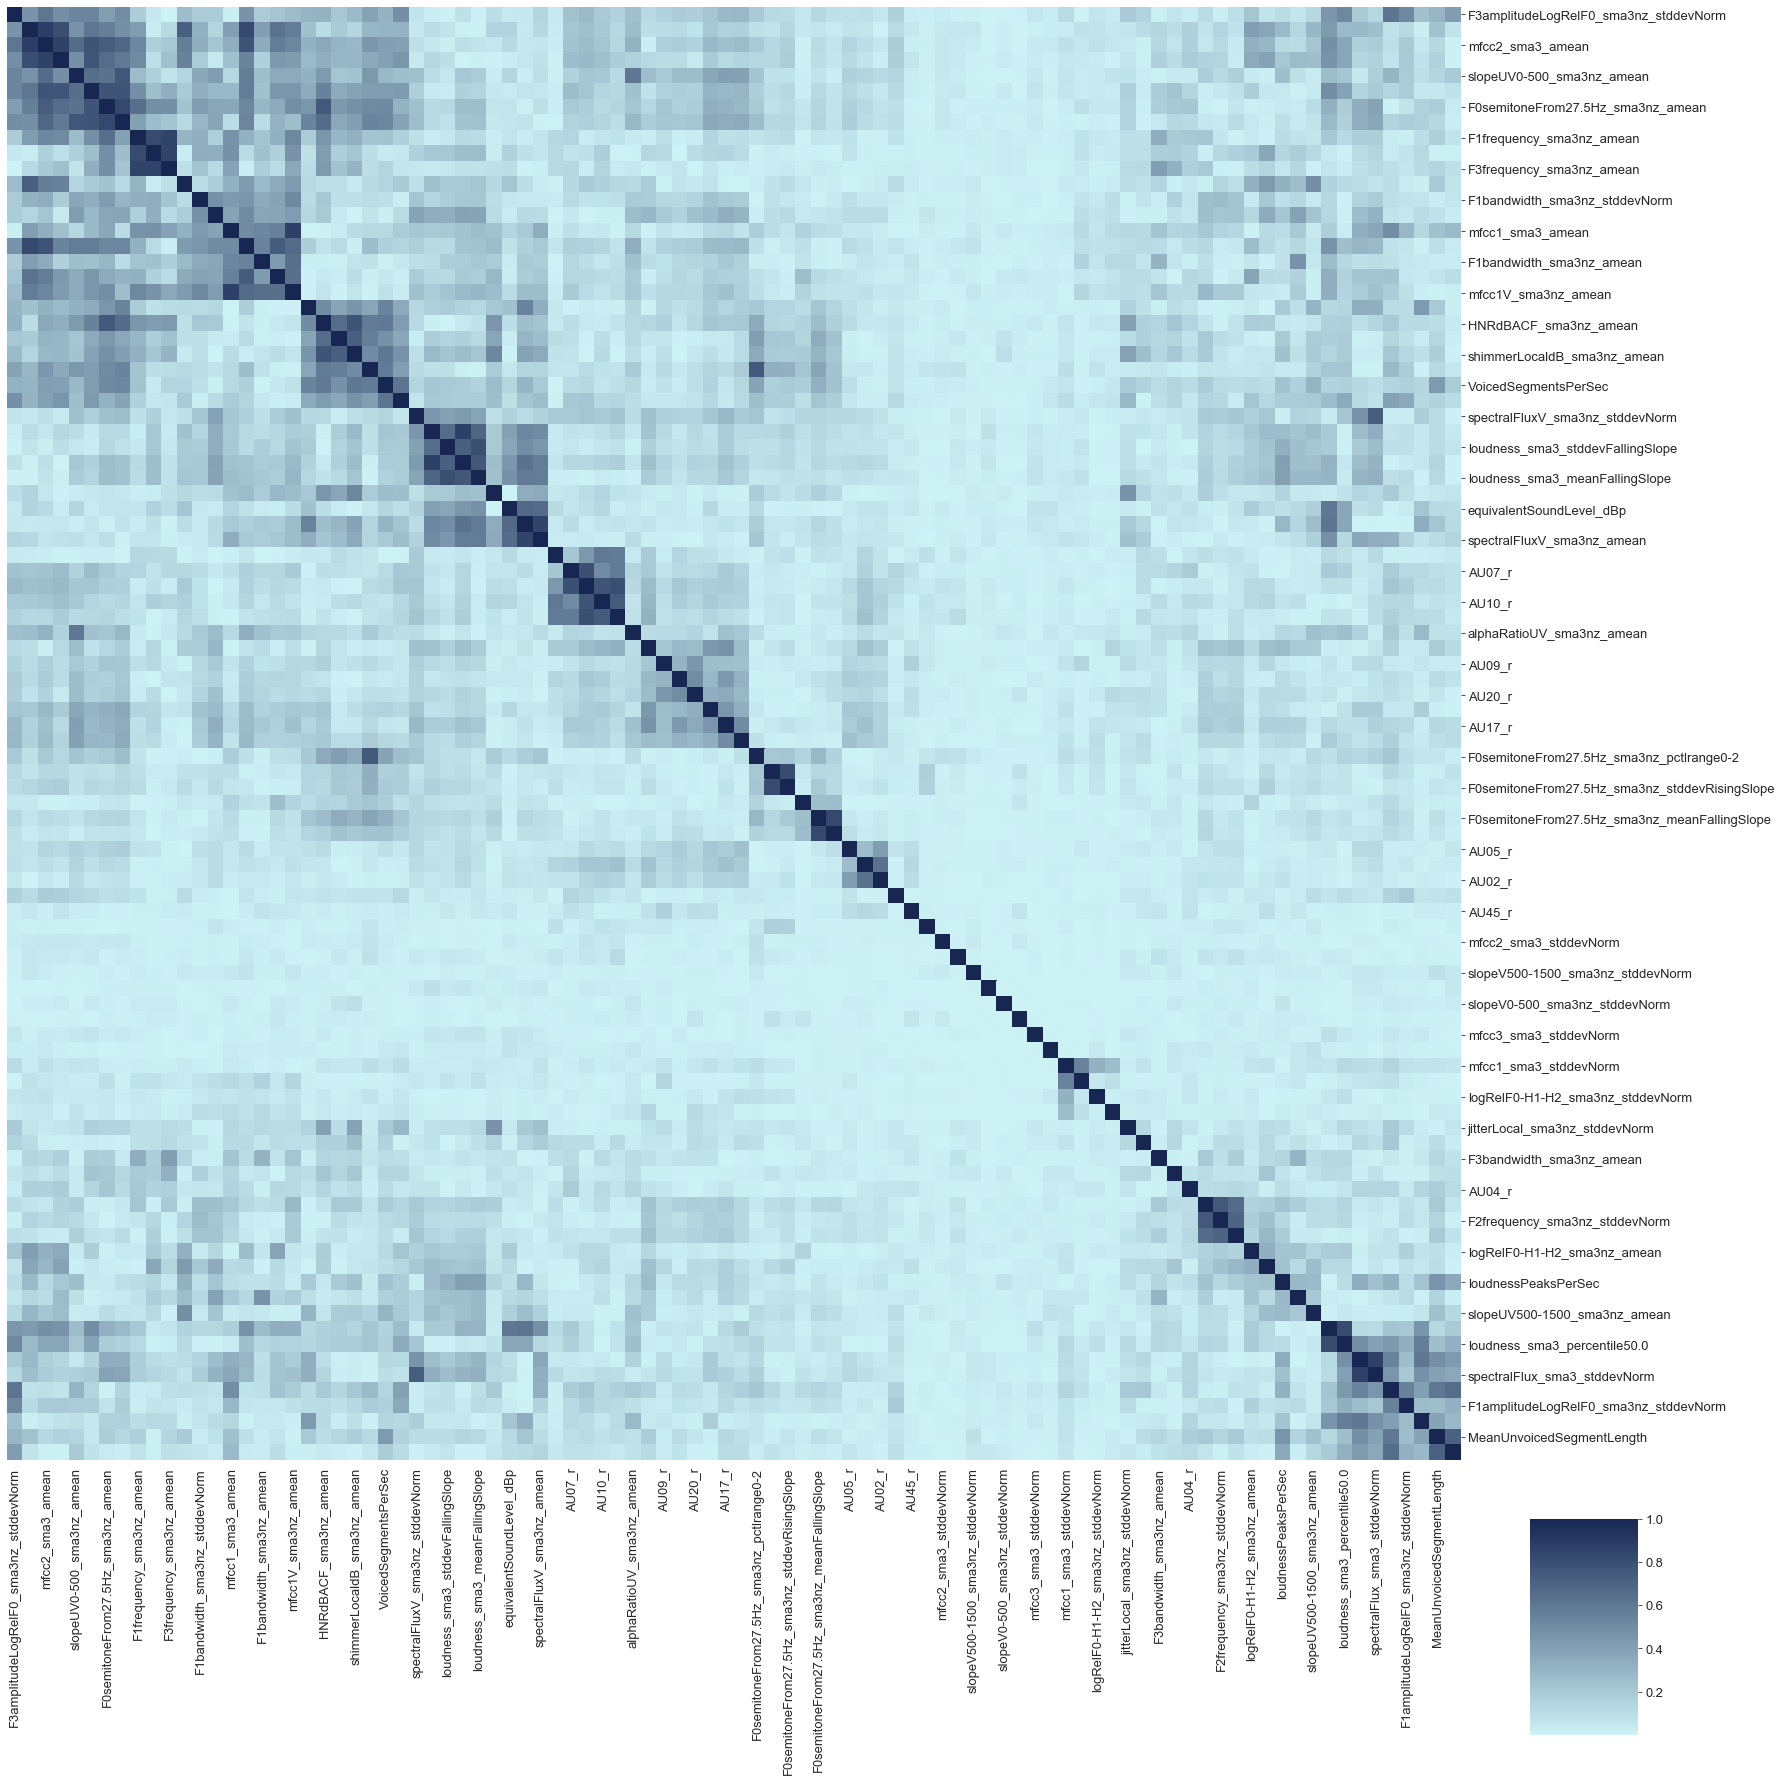

Number of dimensions before dimensionality reduction: 105
Number of dimensions after dimensionality reduction: 94


In [10]:
# https://youtu.be/ioXKxulmwVQ?t=899
# https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
X = multi_df.drop(columns='emotion')
y = multi_df.emotion

# Create correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than corr_tol (corelation tolerance)
corr_tol = 0.9
to_drop = [column for column in upper.columns if any(upper[column] > corr_tol)]

# Drop features
df_tmp = multi_df.copy()
reduced_df = df_tmp.drop(df_tmp[to_drop], axis=1)
X_reduced = reduced_df.drop(columns='emotion')
reduced_df = pd.concat([X_reduced,y], axis=1)
reduced_df.to_csv(os.path.join(output_path, 'data', 'audio_video_dataset_unsupervised_learning_reduced.csv'), index=None, header=True)

cg = sns.clustermap(X_reduced.corr().abs(), cmap=pos_cmap, metric='cityblock', cbar_pos=(0.88, 0.025, 0.05, 0.10), figsize=(30,30))
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.ax_row_dendrogram.set_xlim([0,0])
plt.savefig(os.path.join(output_path,'charts','corr_expl_after_dim_red.svg'), bbox_inches = 'tight')
plt.show()

print('Number of dimensions before dimensionality reduction:', len(X.columns))
print('Number of dimensions after dimensionality reduction:', len(X_reduced.columns))